This notebook contains code exploring the power of an attack on round-by-round risk-limiting audits noticed by Arkady Yerukhimovich during the defense of Oliver Broadrick's MS thesis at GW.

Round-by-round RLAs begin by rolling dice (or some other random procedure) to produce a random seed for the pseudorandom number generator that is used to generate the random samples for the audit. Once the seed has been generated though, and adversary choosing the round sizes of the audit who has prior knowledge of the true contents of each ballot may be able to increase the risk of the audit beyond the risk limit. 

We begin by exploring the most powerful version of such an adversary, one who knows the true contents of every single ballot. 

In [1]:
# Imports
from r2b2.contest import ContestType, Contest
from r2b2.minerva2 import Minerva2
from r2b2.minerva import Minerva
from r2b2.eor_bravo import EOR_BRAVO
from r2b2.so_bravo import SO_BRAVO
import pandas as pd
import numpy as np

In [2]:
tally = {'Alice' : 600, 'Bob' : 400}
p1 = tally['Alice'] / sum(tally.values())
p0 = 1/2

Now we set the audit parameters.

In [3]:
# Risk-limit
risk_limit = .1
alpha = risk_limit

# Some useful constants
reported_winner = max(tally, key=tally.get) 
winner_votes = tally[reported_winner]
total_relevant = sum(tally.values())
loser_votes = total_relevant - winner_votes
margin = (winner_votes / total_relevant) - (loser_votes / total_relevant)

# Make the contest object
contest_reported = Contest(total_relevant, 
                            tally, 
                            num_winners=1, 
                            reported_winners=[reported_winner],
                            contest_type=ContestType.PLURALITY)

# Make the audit objects. While we are running a Minerva 2.0 audit, 
# we might as well compute other ballot-polling RLA numbers...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
minerva2 = Minerva2(risk_limit, 1.0, contest_reported)
minerva = Minerva(risk_limit, 1.0, contest_reported)
so_bravo = SO_BRAVO(risk_limit, 1.0, contest_reported)
eor_bravo = EOR_BRAVO(risk_limit, 1.0, contest_reported)

# Print out the audit parameters
print("Tally: {}".format(tally))
print("Total Ballots: {}".format(sum(tally.values())))
print("Margin: {}".format(margin))
print("Risk Limit: {}".format(risk_limit))

Tally: {'Alice': 600, 'Bob': 400}
Total Ballots: 1000
Margin: 0.19999999999999996
Risk Limit: 0.1


/opt/homebrew/lib/python3.10/site-packages/scipy/stats/_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


In [4]:
from kmin_minerva2 import kmin_minerva2

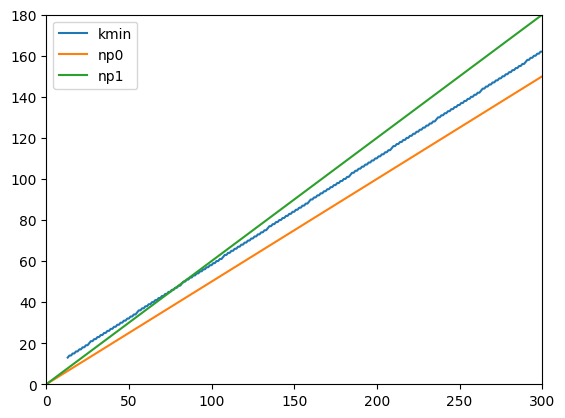

In [5]:
# going into a round, there are many possible round sizes, 
# and for each one there is an associated k_min
N = 300
ns = np.arange(1, N+1)
kmins = []
for i in range(len(ns)):
    kmin = kmin_minerva2(1, ns[i], 0, 0, p1, p0, alpha)
    kmins.append(kmin)

# plot
from matplotlib import pyplot as plt
plt.plot(ns,kmins,label='kmin')
plt.plot(ns,ns*p0,label='np0')
plt.plot(ns,ns*p1,label='np1')
plt.ylim([0,p1*N])
plt.xlim([0,N])
plt.legend()
plt.show()


The question is, for a given true underlying distribution (e.g. p0<.5) how often (for what proportion of possible random samples) will there be a reasonable next round size choice that exceeds its k_min, i.e. stops. This is exactly the true risk of the audit in the presence of the Arkady-style adversary. Note that the wrongly assumed risk of the audit is just the probability that the audit stops (k>kmin) conditioned on the round size. How much greater is the true risk than the assumed risk -- how powerful is Arkady's adversary?

In [6]:
def true_risk(N, kmins, p):
    """
    Computes the true risk of the first round of an audit assuming that an 
    adversary who knows the next sample's true conents can choose the next 
    round size. 

    Arguments:
        N (int): maximum acceptable next round size
        kmins ([]): kmins[i] is the minimum winner ballots in a round of 
                    size i+1 for the audit to stop
        p (float): true underlying proportion of votes for the reported 
                    winner  

    """
    # Initialize distributions: 1 at 0 and 0 everywhere else
    prev_dist = np.append([1], np.zeros([N]))
    curr_dist = np.zeros([N])

    # Track cumulative probability of stopping (risk)
    sprob = 0

    # Dynamic programming approach: 
    # For each round size n in [1...N], compute the
    # distribution over k (reported winner ballots) using the 
    # same distribution for size n-1 and the true underlying proportion p.
    for n in range(1,N+1):
        # Compute the distribution over winner ballots for round size n
        # based on the previous distribution (for size n-1).
        curr_dist = np.roll(prev_dist, 1) * p + prev_dist * (1-p)

        # Get kmin.
        kmin = kmins[n-1]

        # Record the proportion of samples for which the audit stops.
        if kmin is not None:
            sprob += sum(curr_dist[kmin:])

        # Now update the curr_dist to stop tracking samples which have 
        # already stopped.
        if kmin is not None:
            curr_dist[kmin:] = 0

        # Update prev_dist for next iteration.
        prev_dist = curr_dist
        
    # Return the true risk (probability of stopping under the 
    # true, underlying distribution)
    return sprob

In [29]:
# function to get kmins for round sizes up to N
def get_kmins(N, p1, p0, alpha):
    ns = np.arange(1, N+1)
    kmins = []
    kminprev = 0
    for i in range(len(ns)):
        kmin = kmin_minerva2(1, ns[i], 0, 0, p1, p0, alpha, kmin_lb=kminprev)
        kmins.append(kmin)
        kminprev = kmin
    return kmins

In [30]:
N = 20000
kmins = get_kmins(N, p1, p0, alpha)
print('kmins found')
true_risk(N, kmins, p0)

kmins found


0.5986847177159049

Perhaps in the limit, this adversary always succeeds. For huge round sizes, there will (almost) surely be some intermediate cumulative tally which surpasses kmin. Realistically though, an auditor is not going to propose a round size of 100,000 for a wide-margin contest. What round sizes can they reasonably propose? Well, let's again be generous to the adversary to explore the potential of this attack and say that any round size up to one which achieves a 99% probability of stopping. Auditors frequently choose 90% stopping probability round sizes and at least one pilot audit has used a 95% stopping probability round size. (Note that here, stopping probability corresponds to the probability of stopping assuming the reported margin is correct.)

In [39]:
from round_size_minerva2 import round_size_minerva2
sprob = .99
N = round_size_minerva2(1, 0, 0, p1, p0, alpha, sprob)
print(N)
kmins = get_kmins(N, p1, p0, alpha)
print('kmins found')
true_risk(N, kmins, p0)

329
kmins found


0.28062101566536257

Now we can explore how this true risk achievable by the adversary varies as a function of various parameters, including: the true margin, the reported margin, the risk limit, the maximum allowable round size (i.e. the maximum allowable stopping probability allowable)

In [81]:
max_sprob = .99
alpha = .1
p0 = .5
margins = [.6, .5, .4, .3, .2, .1, .05]
risks = []
for margin in margins:
    p1 = (margin + 1)/2      #p1-(1-p1) = margin  -->  p1 = (margin + 1)/2
    N = round_size_minerva2(1, 0, 0, p1, p0, alpha, max_sprob)
    kmins = get_kmins(N, p1, p0, alpha)
    risk = true_risk(N, kmins, .5)
    risks.append(risk)

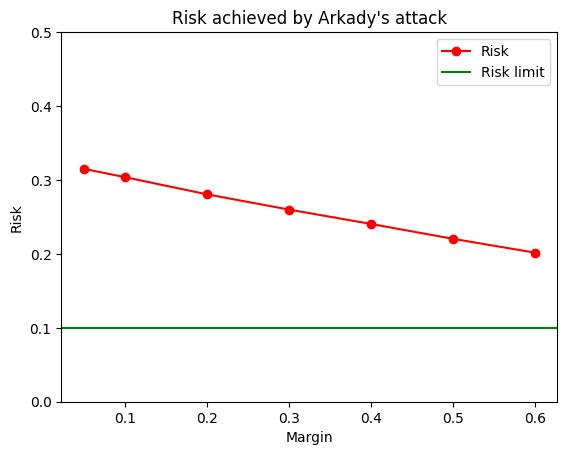

In [82]:
plt.plot(margins, risks, label='Risk',color='red',marker='o')
plt.axhline(alpha,0,1,label='Risk limit',color='green')
plt.legend()
plt.ylim([0,.5])
plt.title('Risk achieved by Arkady\'s attack')
plt.xlabel('Margin')
plt.ylabel('Risk')
plt.show()

In [148]:
# if the choice of round size is unbounded, how high does the true risk become?

# to explore this question, it might be useful to think of each ballot as a -1 or +1 rather than a 0 or +1.
# this way, we imediately have a martingale (in the p=0.5 case). let's plot k_min in this adjusted domain
# and see if we can get a sense of the probability with which the sample will exceed k_min at some point
alpha = .1
p0 = .5
margin = .1
p1 = (margin + 1)/2      #p1-(1-p1) = margin  -->  p1 = (margin + 1)/2
N = 10**4
kmins = np.array(get_kmins(N, p1, p0, alpha))
risk = true_risk(N, kmins, .5)
risks.append(risk)
ns = np.arange(1,N+1)
# plot
from matplotlib import pyplot as plt

kmins_adj = np.empty_like(kmins)
for i in range(len(kmins)):
    if kmins[i] is None:
        kmins_adj[i] = None
    else:
        kmins_adj[i] = kmins[i] - (ns[i] - kmins[i])

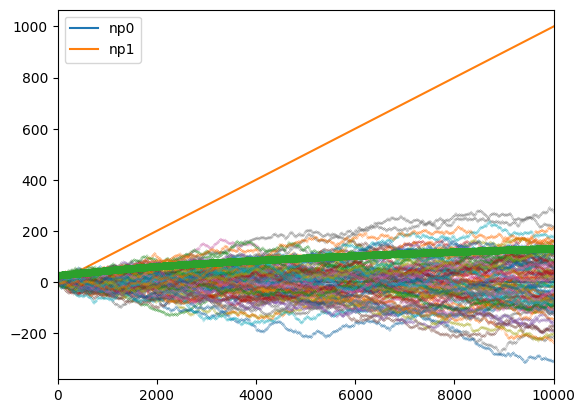

[-8, -7, -8, -7, -6, -7, -6, -7, -6, -7]

In [161]:
# random samples
import random
random.seed(1)
samples = []
numsamples = 100
for i in range(numsamples):
    samples.append([0])
    for j in range(len(kmins)):
        if random.getrandbits(1) == 1:
            samples[i].append(samples[i][j] + 1)
        else:
            samples[i].append(samples[i][j] - 1)

plt.plot(ns,ns*p0 -(ns-ns*p0),label='np0')
plt.plot(ns,ns*p1 -(ns-ns*p1),label='np1')
#plt.ylim([-(p1*N-(N-p1*N)),p1*N-(N-p1*N)])
plt.xlim([0,N])
for i in range(numsamples):
    plt.plot(ns,samples[i][1:],marker='.',markersize=.03,linestyle='')
plt.legend()
plt.plot(ns,kmins_adj,label='kmin',linewidth='5')
plt.show()
samples[1][50:60]